# ENet -  Real Time Semantic Segmentation for Road segmentation

**Journal paper:**<br/>
Link to the paper: https://arxiv.org/pdf/1606.02147.pdf <br/>
**Code references**<br/>
python implementation :https://github.com/iArunava/ENet-Real-Time-Semantic-Segmentation<br/>
lua implemenattion by paper author : https://github.com/e-lab/ENet-training

Daya Alex 5/4/24

## Install the dependencies and Import them

In [1]:
#%pip install pytorch-lightning

In [2]:
#pip install segmentation_models_pytorch

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from torchvision import transforms
import math
import random
from torchmetrics import JaccardIndex
import albumentations as A
from torch.utils.data import DataLoader, Dataset
#from segmentation_models_pytorch.losses import DiceLoss

# import sys
# sys.path.append('/kaggle/input/') 
# print(sys.path)
import metrics

from torch.optim.lr_scheduler import StepLR
#import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
import glob

import wandb



In [4]:
os.environ['WANDB_API_KEY'] = '022c1b388c10d71b380a05f47bab773ce231dcb5'

## Create the ENet model

We decided to to split the model to three sub classes:

1) Initial block  

2) RDDNeck - class for regular, downsampling and dilated bottlenecks

3) ASNeck -  class for asymetric bottlenecks

4) UBNeck - class for upsampling bottlenecks

In [5]:
class InitialBlock(nn.Module):
  
  # Initial block of the model:
  #         Input
  #        /     \
  #       /       \
  # maxpool2d    conv2d-3x3
  #       \       /  
  #        \     /
  #      concatenate
  #          |
  #         Batchnorm
 #        PReLU
   
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(16)
  
    def forward(self, x):
        
        main = self.conv(x)
        side = self.maxpool(x)
        #print('main size ', main.size)
        #print('side size ', side.size)
        # concatenating on the channels axis
        x = torch.cat((main, side), dim=1)
        x = self.batchnorm(x)
        x = self.prelu(x)
        #print('init block size ',x.shape)
        
        return x

In [6]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
    
  # Regular|Dilated|Downsampling bottlenecks:
  #
  #     Bottleneck Input
  #        /        \
  #     Identity     \  
  #       /          \
  # maxpooling2d   conv2d-1x1(when downsamp flag is ON, otherwise 2x2)
  # (when downsamp)    | BN +PReLU
  # (-flag is ON)    conv2d-3x3
  #      |             | BN +PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer(BN + dropout)
  #(when i/p ch !=o/p ch) /   
  #        \            /
  #      Summing + PReLU
  #
  # Params: 
  #  dilation (bool) - if True: creating dilation bottleneck
  #  down_flag (bool) - if True: creating downsampling bottleneck
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  #  p - dropout ratio
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(out_channels // projection_ratio)
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag
        
        # calculating the number of reduced channels
        if self.down_flag:
            self.stride = 2
            self.conv1_kernel = 2
        else:
            self.stride = 1
            self.conv1_kernel = 1
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        
        self.dropout = nn.Dropout2d(p=p)

        self.prelu1 = activation
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = self.conv1_kernel,
                               stride = self.stride,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 1,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        self.identity = nn.Identity()
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = self.identity(x)
        
        # Main
        x = self.conv1(x)
        #print(" Conv1 called ")
        x = self.batchnorm(x)
        x = self.prelu1(x)
        #print(self.conv1_kernel, self.stride, x.shape)
        
        x = self.conv2(x)
        #print(" Conv2 called ")
        x = self.batchnorm(x)
        x = self.prelu2(x)
        #print(self.conv2.kernel_size, self.stride,self.dilation, x.shape)
        
        x = self.conv3(x)
        #print(" Conv3 called ")
        x = self.batchnorm2(x)     
        x = self.dropout(x)
        #print(self.conv3.kernel_size, self.stride, x.shape)
        
        #other
        if self.down_flag:
            #print('downsampling flag is true')
            x_copy, indices = self.maxpool(x_copy)
            
          
        if self.in_channels != self.out_channels:
            #print('input and output channels diffrence, so padding of side channel being carried out')
            out_shape = self.out_channels - self.in_channels
            #print('extra channels required ', out_shape)
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            #elif torch.backends.mps.is_available():
                #extras = extras.to('mps')
            #print('x copy shape ',x_copy.shape)
            #print('extras shape ', extras.shape)
            x_copy = torch.cat((x_copy, extras), dim = 1)
            #print('final side route shape ,', x_copy.shape)

        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        #print('final layer ', x.shape)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [7]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
      
  # Asymetric bottleneck:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  #      |         conv2d-1x1
  # Identity           | PReLU
  #      |         conv2d-1x5
  #      |             |
  #      |         conv2d-5x1
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #       \     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params:    
  #  projection_ratio - ratio between input and output channels
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(out_channels // projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = True)############TRUE bias in original code###############
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        self.identity = nn.Identity()
        
    def forward(self, x):
   
        #main branch
        x_copy = self.identity(x)
        #print('side branch')
        
        # Side Branch
        x = self.conv1(x)
        #print('conv1 called')
        x = self.batchnorm(x)
        x = self.prelu1(x)
        #print(self.conv1.kernel_size,self.conv1.stride, x.shape)
        
        x = self.conv21(x)
        #print('conv21 called')
        #print(self.conv21.kernel_size, self.conv21.stride, x.shape)
        x = self.conv22(x)
        #print('conv22 called')
        #print(self.conv22.kernel_size, self.conv22.stride, x.shape)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        #print('conv3 called')   
        x = self.dropout(x)
        x = self.batchnorm2(x)
        #print('final main ',self.conv3.kernel_size,self.conv3.stride, x.shape)

        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        #print('final total ', x.shape)
        
        return x

In [8]:
class loss_function(nn.Module):
    def __init__(self, class_weights):
        super().__init__()

        self.register_buffer('cls_wts', class_weights)
        self.criterion = nn.CrossEntropyLoss(weight = self.cls_wts)

    def forward(self, out, target):
        loss = self.criterion(out, target)
        return loss



In [9]:
class ENetEncoder(pl.LightningModule):
  #to do, write a description 
  
    def __init__(self, C, class_weights, lr=5e-4, weight_decay=2e-4 ):
        super().__init__()
        
        # Define class variables
        self.C = C
        self.class_weights = class_weights
        self.loss = loss_function(self.class_weights)
        self.tp, self.fp, self.fn, self.tn = 0,0,0,0
        self.maxiou = 10e-4#keeping as very small number

        self.save_hyperparameters()#saves the hyperparameters defined in __init__ and can be accessed using self.hparams['key']

        # The initial block
        self.init = InitialBlock()
       
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1,
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        #fully convolutional layer to get the encoder output
        self.enc_conv = nn.Conv2d(in_channels=128,
                                 out_channels = 12,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0,
                                 bias =False)
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        #print('^^^^^^^^^^^^^^init block^^^^^^^^^^^^^^^^')
        
        # The first bottleneck
        x, i1 = self.b10(x)
        #print('................bottleneck_10 complete................')
        x = self.b11(x)
        #print('................bottleneck_11 complete...........')
        x = self.b12(x)
        #print('...............bottleneck_12 complete............')
        x = self.b13(x)
        #print('............bottleneck_13 complete............')
        x = self.b14(x)
        #print('.................bottleneck_14 complete.............')
        
        # The second bottleneck
        x, i2 = self.b20(x)
        #print('----------------bottleneck_20 complete-----------')
        x = self.b21(x)
        #print('----------------bottleneck_21 complete-----------')
        x = self.b22(x)
        #print('-----------bottleneck_22 complete--------------')
        x = self.b23(x)
        #print('-----------bottleneck_23 complete---------------')
        x = self.b24(x)
        #print('--------------bottleneck_24 complete------------')
        x = self.b25(x)
        #print('-------------bottleneck_25 complete------------')
        x = self.b26(x)
        #print('-------------bottleneck_26 complete-------------')
        x = self.b27(x)
        #print('-------------bottleneck_27 complete-------------')
        x = self.b28(x)
        #print('------------bottleneck_28 complete----------------')
        
        # The third bottleneck
        x = self.b31(x)
        #print('********bottleneck_31 complete************')
        x = self.b32(x)
        #print('********bottleneck_32 complete************')
        x = self.b33(x)
        #print('********bottleneck_33 complete************')
        x = self.b34(x)
        #print('********bottleneck_34 complete************')
        x = self.b35(x)
        #print('********bottleneck_35 complete************')
        x = self.b36(x)
        #print('********bottleneck_36 complete************')
        x = self.b37(x)
        #print('********bottleneck_37 complete************')
        x = self.b38(x)
        #print('********bottleneck_38 complete************')
        
        x = self.enc_conv(x)
        
        return x

    def training_step(self, batch, batch_idx):
        
        X_batch, mask_batch = batch
        out = self(X_batch.float()) 
        train_loss = self.loss(out, mask_batch.long())

        self.log('train/loss', train_loss, on_step = True, on_epoch = True)
        return train_loss

    def on_validation_epoch_start(self):#hook
        self.val_step_outputs = [] #we will fill this with the logits(prediction)

    def validation_step(self, batch, batch_idx):
        #print(f"Batch index: {batch_idx}, Batch size: {len(batch)}")
        X_batch, mask_batch = batch
        out = self(X_batch.float())
        self.val_step_outputs.append(out)

        val_loss = self.loss(out, mask_batch.long())

        _, predicted_classes = torch.max(out, dim = 1)# to get the id of the channel having largest prob (argmax of prob) 
        this_tp, this_fp, this_fn, this_tn = metrics.get_stats(
                                                predicted_classes, mask_batch.long(), mode = "multiclass", num_classes= 12
        )

        self.tp += this_tp 
        self.fp += this_fp 
        self.fn += this_fn 
        self.tn += this_tn 
                
        self.log('val/loss', val_loss,  on_step = False, on_epoch = True) 
        return out
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.hparams.lr, weight_decay = self.hparams.weight_decay) 
        return {"optimizer": optimizer, 
                "lr_scheduler": {
                    "scheduler":StepLR(optimizer, step_size = 100, gamma = 0.1 ),
                    "monitor":'val_loss'}
                }

    def on_validation_epoch_end(self):#hook
        miou_score = metrics.iou_score(sum(self.tp), sum(self.fp), sum(self.fn), sum(self.tn), reduction = 'micro')
        self.log('val/val_accuracy', miou_score )
        if miou_score > self.maxiou:
            self.maxiou = miou_score
            checkpoint = {
                'epochs' : self.current_epoch,
                'state_dict': self.state_dict(),
                'miou': self.maxiou
            } 
            torch.save(checkpoint, f'./CNNEncoder_for_ENet_trained_on_Camvid_epoch{self.current_epoch}_acc{self.maxiou:.3f}.pth') #checkpoint,checkpoint path   
            self.log('New best model saved with miou:', self.maxiou)   
        self.tp, self.fp, self.fn, self.tn  = 0,0,0,0#reseting for next epoch calculation

    def test_step(self, batch, batch_idx):
        X_batch, mask_batch = batch
        out = self(X_batch.float())
        test_loss = self.loss(out, mask_batch.long())
        
        _, predicted_classes = torch.max(out, dim = 1)
        this_tp, this_fp, this_fn, this_tn = metrics.get_stats(
                                                predicted_classes, mask_batch.long(), mode = "multiclass", num_classes= 12
        )

        self.tp += this_tp 
        self.fp += this_fp 
        self.fn += this_fn 
        self.tn += this_tn 

        self.log('test/loss', test_loss, on_step = False, on_epoch = True)
        return test_loss

    def on_test_epoch_end(self):#hook
        miou_score = metrics.iou_score(sum(self.tp), sum(self.fp), sum(self.fn), sum(self.tn), reduction = 'micro')
        self.log('test/test_accuracy', miou_score )
        self.tp, self.fp, self.fn, self.tn  = 0, 0, 0, 0

        dummy_input = torch.zeros((1,3,360,480), device=self.device)
        model_filename = f"model_{self.current_epoch}.onnx"
        torch.onnx.export(self, dummy_input, model_filename, opset_version=11)
        artifact = wandb.Artifact(name="test_enet_model", type="model")
        artifact.add_file(model_filename)
        self.logger.experiment.log_artifact(artifact)
        
    

In [10]:
class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=3):
        super().__init__()
        self.X_img_samples, self.mask_samples = val_samples
        self.X_img_samples= self.X_img_samples[:num_samples]
        self.mask_samples= self.mask_samples[:num_samples] 

    def on_validation_epoch_end(self, trainer, pl_module):#remember model is now pl_module

        self.X_img_samples = self.X_img_samples.to(pl_module.device)
        output_samples = pl_module(self.X_img_samples)

        table = wandb.Table(columns = ["images", "predictions", "targets"] 
            )
        for X_img, output, mask in zip(self.X_img_samples.to("cpu"), output_samples.to("cpu"), self.mask_samples.to("cpu")):
            segmap_pred = decode_segmap(output.data.max(0)[1].numpy())#pass the max prob channel
            segmap_gt = decode_segmap(mask.numpy())
        
            table.add_data(wandb.Image(X_img.numpy().transpose(1,2,0)*255), 
                    wandb.Image(segmap_pred), 
                    wandb.Image(segmap_gt)
                    )    

        trainer.logger.experiment.log(
            {'val_images_table': table}
        )

        validation_step_outputs = getattr(pl_module, 'val_step_outputs', None)#returns None when  'val_step_outputs' cannot be found
        flattened_logits = torch.flatten(torch.cat(validation_step_outputs))
        trainer.logger.experiment.log(
            {
                'valid/logits':flattened_logits,
                'global_step':trainer.global_step
            }
        )


## Data 

In [11]:
def verify_dataset_normalization(loader,h=360,w=480):
    """finds mean and std dev for whole data batch
    """
    # Initialize accumulators
    channel_sum = torch.tensor([0.0, 0.0, 0.0])
    channel_squared_sum = torch.tensor([0.0, 0.0, 0.0])
    num_batches = 0

    for images, _ in loader:
        #print(images.shape)
        # Accumulate sum and squared sum for each channel
        channel_sum += images.sum(dim=[0, 2, 3])
        channel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])
        num_batches += images.shape[0]

    # Calculate mean and standard deviation
    mean = channel_sum / (num_batches * h * w)
    std = (channel_squared_sum / (num_batches * h * w) - mean ** 2) ** 0.5

    return mean, std

In [12]:
def augmentation(mode='train', h= 360, w =480):
    """ resizes image to input size and mask to a downsampled size, 
        applies horizontal flip and color jitter augmentation only to trainsets
        
    """
    if mode == 'train':
        img_transformation = A.Compose([
                        A.Resize(h,w),
                        A.HorizontalFlip(p= 0.5),
                        #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

                    ])
        #mask size different from image size
        mask_transformation = A.Compose([
                    A.Resize(h//8, w//8),
                    A.HorizontalFlip(p=0.5)
                    ])
        
    else:
        img_transformation =A.Resize(h, w)
        mask_transformation = A.Resize(h//8, w//8)
        
    return img_transformation,  mask_transformation

In [13]:
def get_wts(dataset):
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    hist = torch.zeros(12)
    for batch in tqdm(loader):
        _, mask = batch
        #print(mask.shape)
        mask = mask.squeeze(0).float()
        #print(mask.shape)

        hist += torch.histc(mask, 12, 0,11 )

    norm_hist = hist/torch.sum(hist)

    class_wts = torch.ones(12)
    for idx in range(12):
        if hist[idx]<1 or idx ==11:
            class_wts[idx] = 0
        else:
            class_wts[idx] = 1/torch.log(1.02 + norm_hist[idx])

    return class_wts


In [14]:
class CamvidDataset(Dataset):
    """custom camvid datset that returns images and the corresponding masks after augmentation and normalisation  
        
    """
    def __init__(self, img_path, mask_path, augmentation, norm_transform=True, road_idx=None):
        self.filenames_t = os.listdir(img_path)
        self.img_path = img_path
        self.mask_path = mask_path
        self.norm_transform = norm_transform
        self.augmentation = augmentation
        #for exttracting road mask
        #self.road_idx = road_idx 

    def __len__(self):
        return len(self.filenames_t)

    def __getitem__(self, idx):
        each_img_path = os.path.join(self.img_path, self.filenames_t[idx])
        each_mask_path = os.path.join(self.mask_path, self.filenames_t[idx])
        
#         img = cv2.imread(each_img_path, cv2.COLOR_BGR2RGB)
        img = cv2.imread(each_img_path, cv2.IMREAD_COLOR)  # Load the image in BGR color space
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)         # Convert from BGR to RGB

        label_array = cv2.imread(each_mask_path, cv2.IMREAD_GRAYSCALE)#h,w array datatype
        label = np.expand_dims(label_array, axis = -1)#h,w,c
        
        if self.augmentation:
            img_transforms, mask_transforms = self.augmentation
            seed = 7
            random.seed(seed)
            img = img_transforms(image=img)['image']# albumentations must be passed with named argument, and gets stored with that name as key
            random.seed(seed)
            mask = mask_transforms(image=label)['image']
            
        if self.norm_transform:
            normalize_tensor = transforms.Compose([
                            transforms.ToTensor(),
                                     ])
            img = normalize_tensor(img)
            
        if not isinstance(mask, torch.Tensor):
            mask = torch.tensor(mask, dtype=torch.uint8)
        mask = mask.permute(2, 0, 1)#c,h,w
        #print(mask.shape)
        mask = mask.squeeze()#h,w
        #print(mask.shape)
        return img, mask


In [15]:
class camvid_lite(pl.LightningDataModule):
    def __init__(self, batch_size=10):
        super().__init__()
        self.batch_size = batch_size

    def prepare_data(self):
        self.class_weights = get_wts(CamvidDataset('/teamspace/uploads/CamVid/train','/teamspace/uploads/CamVid/trainannot',augmentation('train')))

    def setup(self, stage =None):#stage none means 
        if stage =='fit' or stage is None:
            self.train_aug = augmentation('train')
            self.val_aug = augmentation('val')
            self.train_dataset = CamvidDataset('/teamspace/uploads/CamVid/train','/teamspace/uploads/CamVid/trainannot', self.train_aug)
            self.val_dataset = CamvidDataset('/teamspace/uploads/CamVid/val','/teamspace/uploads/CamVid/valannot', self.val_aug)

        if stage =='test' or stage is None:
            self.test_aug = augmentation('val')
            self.test_dataset = CamvidDataset('/teamspace/uploads/CamVid/test','/teamspace/uploads/CamVid/testannot', self.test_aug)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, self.batch_size, shuffle=False, drop_last=True)


In [16]:
datamod = camvid_lite()
datamod.prepare_data()
datamod.setup()

  0%|          | 1/367 [00:00<01:18,  4.67it/s]

100%|██████████| 367/367 [00:57<00:00,  6.40it/s]


In [17]:
model = ENetEncoder(12, datamod.class_weights)

In [18]:
# batch = next(iter(datamod.val_dataloader()))
# batch_idx = 0  # Example batch index
# model.validation_step(batch, batch_idx)

In [19]:

# mean_train, std_train = verify_dataset_normalization(datamod.train_dataloader())
# mean_val, std_val = verify_dataset_normalization(datamod.val_dataloader())
# mean_test, std_test = verify_dataset_normalization(datamod.test_dataloader())

# print(f'mean and std dev of train set is {mean_train}, {std_train}')
# print(f'mean and std dev of val set is {mean_val}, {std_val}')
# print(f'mean and std dev of test set is {mean_test}, {std_test}')

# print('class wts of train ', datamod.class_weights)


mean and std dev of train set is tensor([0.4119, 0.4251, 0.4327]), tensor([0.3071, 0.3116, 0.3072])
mean and std dev of val set is tensor([0.3136, 0.3328, 0.3478]), tensor([0.2392, 0.2682, 0.2658])
mean and std dev of test set is tensor([0.3784, 0.3892, 0.3954]), tensor([0.2934, 0.2956, 0.2948])
class wts of train  tensor([ 6.0922,  4.4581, 34.0328,  3.3760, 14.6258,  9.3756, 28.3469, 29.9506,
        13.2160, 37.3547, 41.8958,  0.0000])


In [20]:
encoder = ENetEncoder(12, datamod.class_weights)

In [21]:
def decode_segmap(image, threshold=0.5):
    
    #print(image)#RGB
    Sky = [0, 0, 0]
    Building = [0, 0, 153]
    Pole = [0, 0, 255]
    Road = [51, 153, 255]
    Pavement = [0, 255, 255]
    Tree = [128, 255, 0]
    SignSymbol = [255, 255, 0]
    Fence = [64, 64, 128]
    Car = [255, 128, 0]
    Pedestrian = [255, 0, 127]
    Bicyclist = [255, 204, 255]
    Background_scene = [255,255,255]

    label_colours = np.array([Sky, Building, Pole, Road, 
                              Pavement, Tree, SignSymbol, Fence, Car, 
                              Pedestrian, Bicyclist, Background_scene]).astype(np.uint8)
    
    #print(label_colours.shape)
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, 12):
        r[image == l] = label_colours[l, 0]
        g[image == l] = label_colours[l, 1]
        b[image == l] = label_colours[l, 2]

    rgb = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b
    return rgb


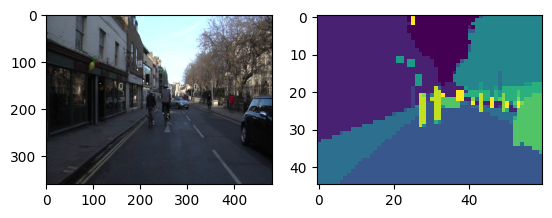

In [22]:
samples = next(iter(datamod.val_dataloader()))
#print(samples)

idx = 7
img, mask = samples
plt.subplot(1,2,1)
plt.imshow(img[idx].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask[idx])
plt.show()

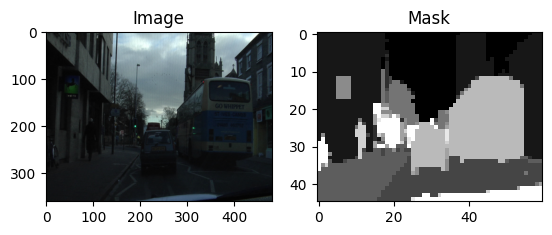

In [23]:
import matplotlib.pyplot as plt

def visualize_sample(dataset, idx):
    
    img, mask = dataset[idx]  # Fetch the image and mask using the dataset's __getitem__ method
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img.permute(1, 2, 0))  # Assuming img is a PyTorch tensor of shape [C, H, W]
    ax[0].set_title("Image")
    ax[1].imshow(mask, cmap='gray')  # Assuming mask is a PyTorch tensor of shape [C, H, W] and C=1 for grayscale
    ax[1].set_title("Mask")
    plt.show()

# Example usage

visualize_sample(datamod.train_dataset, 5)  # Visualize the first sample in the train dataset


torch.Size([3, 360, 480]) torch.Size([45, 60])


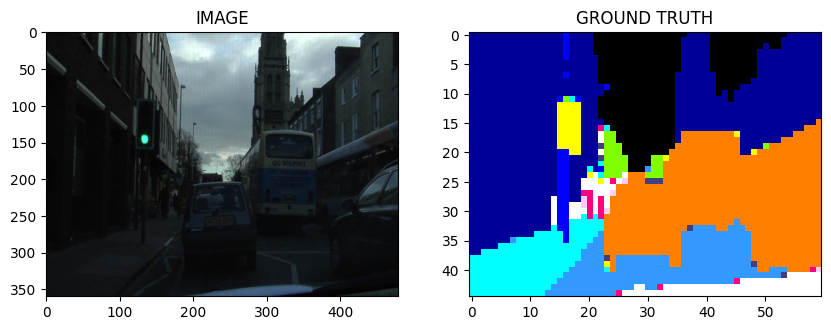

In [24]:
idx = 0

img, mask = datamod.train_dataset[idx]
print(img.shape, mask.shape)
#print(mask)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(img.permute(1,2,0).squeeze())
        
ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.squeeze(),cmap = 'gray')
mask_segmap =decode_segmap(mask.squeeze().numpy())

ax2.imshow(mask_segmap)

In [25]:
# class Idd7ClassesDataset(Dataset):
#     def __init__(self, img_path, mask_path, augmentation, norm_transform=True, road_idx=None):
#         self.filenames_t = glob.glob(training_path+f'*\*.jpg')
#         self.filenames_s = glob.glob(segmented_path+f'*\*[0-9]_label.png')
#         self.norm_transform = norm_transform
#         self.dual_transform = dual_transform
#         self.road_idx = road_idx

#     def __len__(self):
#         return len(self.filenames_t)

#     def __getitem__(self, idx):
#         img_path = self.filenames_t[idx]
#         mask_path = self.filenames_s[idx]
#         img = cv2.imread(each_img_path, cv2.COLOR_BGR2RGB)
#         label_array = cv2.imread(each_mask_path, cv2.IMREAD_GRAYSCALE)#h,w array datatype
#         label = np.expand_dims(label_array, axis = -1)#h,w,c
        
#         if self.augmentation:
#             img_transforms, mask_transforms = self.augmentation
#             seed = 7
#             random.seed(seed)
#             img = img_transforms(image=img)['image']# albumentations must be passed with named argument, and gets stored with that name as key
#             random.seed(seed)
#             mask = mask_transforms(image=label)['image']
            
#         if self.norm_transform:
#             normalize_tensor = transforms.Compose([
#                             transforms.ToTensor(),
#                             transforms.Normalize([0.3576, 0.3713, 0.3657], 
#                                                 [0.2608, 0.2723, 0.2943])
#                                      ])
#             img = normalize_tensor(img)
            
#         if not isinstance(mask, torch.Tensor):
#             mask = torch.tensor(mask, dtype=torch.uint8)
#         mask = mask.permute(2, 0, 1)#c,h,w
#         #print(mask.shape)
#         mask = mask.squeeze()#h,w
#         #print(mask.shape)

#         return img, mask


## Define the Hyperparameters

## Training loop

In [30]:
def train_using_wandb():
    run = wandb.init(project = 'DISTRIBUTED-pylit-enet-encoder-training-Lightning.ai',
                config = {"lr": 5e-4,
                                "batch_size": 10,
                                "epochs": 5,
                                },
                )
    config = run.config
    run_name = f'pickling debugging lr {config.lr}, epochs {config.epochs}, batch_size: {config.batch_size}'
    wandb.run.name = run_name

    datamod = camvid_lite(batch_size=config.batch_size)
    datamod.prepare_data()
    datamod.setup()

    model = ENetEncoder(C=12, 
                        class_weights=datamod.class_weights, 
                        lr=config.lr, 
                        weight_decay=2e-4)       

    logger = WandbLogger()
    wandb.watch(model, model.loss, log= 'all', log_freq = 360 )#log every 360th batch, the grad, weights
    val_samples = next(iter(datamod.val_dataloader()))


    trainer = pl.Trainer(
        accelerator="gpu", devices=4, strategy="ddp_spawn",
        logger = logger,
        log_every_n_steps = 1,
        max_epochs = config.epochs,
        deterministic = True,
        callbacks = [ImagePredictionLogger(val_samples)]
    )
    trainer.fit(model, datamod)
    trainer.test(datamodule = datamod, ckpt_path = None)


In [31]:
train_using_wandb()

100%|██████████| 367/367 [00:03<00:00, 106.35it/s]


MisconfigurationException: You requested gpu: [0, 1, 2, 3]
 But your machine only has: [0]

## Infer using the trained model

In [ ]:
def show_images(images, in_row=True):
    '''
    Helper function to show 3 images
    '''
    total_images = len(images)

    rc_tuple = (1, total_images)
    if not in_row:
        rc_tuple = (total_images, 1)
    
    #figure = plt.figure(figsize=(20, 10))
    for ii in range(len(images)):
        plt.subplot(*rc_tuple, ii+1)
        plt.title(images[ii][0])
        plt.axis('off')
        plt.imshow(images[ii][1])
    plt.show()

In [ ]:
checkpoint = torch.load('/kaggle/working/encoder camvid 1199th epoch, indices with state_dic.pth')
enc = ENetEncoder(12)
enc = enc.to(device)
state_dict = checkpoint['state_dict']
enc.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/encoder camvid 1199th epoch, indices with state_dic.pth'

In [ ]:
h = 360
w = 480

image_path = '/kaggle/input/camvid-seg-12/CamVid/test/0001TP_008730.png'
# Assuming the dataset is camvid

tmg_ = plt.imread(image_path)
tmg_ = cv2.resize(tmg_, (h, w), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2)
tmg = tmg.to(device)

enc.eval()
with torch.no_grad():
    out1, id1, id2 = enc(tmg.float())
    out1 = out1.squeeze(0)
b_ = out1.data.max(0)[1].cpu().numpy()

decoded_segmap = decode_segmap(b_)

gt_path = image_path.replace('test','testannot') 
gt = plt.imread(gt_path)
gt = cv2.resize(gt, (h//8, w//8), cv2.INTER_NEAREST)
gt = decode_segmap(gt*255)

images = {
 0 : ['Input Image', tmg_],
 1 : ['Predicted Segmentation', decoded_segmap],
 2 : ['ground truth', gt]
}

plt.title('cross_entropy_multi-class_1200_epochs')

show_images(images)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/camvid-seg-12/CamVid/test/0001TP_008730.png'

In [ ]:
checkpoint = torch.load('/teamspace/studios/this_studio/CNNEncoder_for_ENet_trained_on_Camvid_epoch0_acc0.2392478585243225.pth')
enc = ENetEncoder(12, datamod.class_weights)
state_dict = checkpoint['state_dict']
enc.load_state_dict(state_dict)

<All keys matched successfully>

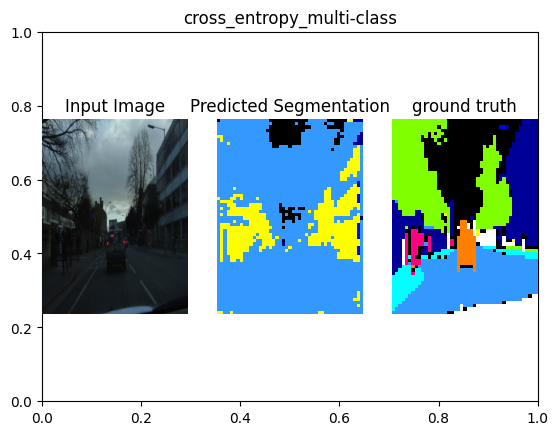

In [ ]:
h = 360
w = 480

image_path = '/teamspace/uploads/CamVid/test/0001TP_008730.png'
# Assuming the dataset is camvid

tmg_ = plt.imread(image_path)
tmg_ = cv2.resize(tmg_, (h, w), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2)
#tmg = tmg.to(device)
enc.eval()
with torch.no_grad():
    out1 = enc(tmg.float())
    out1 = out1.squeeze(0)
b_ = out1.data.max(0)[1].cpu().numpy()

decoded_segmap = decode_segmap(b_)

gt_path = image_path.replace('test','testannot') 
gt = plt.imread(gt_path)
gt = cv2.resize(gt, (h//8, w//8), cv2.INTER_NEAREST)
gt = decode_segmap(gt*255)

images = {
 0 : ['Input Image', tmg_],
 1 : ['Predicted Segmentation', decoded_segmap],
 2 : ['ground truth', gt]
}

plt.title('cross_entropy_multi-class')

show_images(images)

In [ ]:
from torchsummary import summary

summary(enc, input_size=(3, 360, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 13, 180, 240]             364
         MaxPool2d-2          [-1, 3, 180, 240]               0
       BatchNorm2d-3         [-1, 16, 180, 240]              32
             PReLU-4         [-1, 16, 180, 240]              16
      InitialBlock-5         [-1, 16, 180, 240]               0
          Identity-6         [-1, 16, 180, 240]               0
            Conv2d-7          [-1, 16, 90, 120]           1,024
       BatchNorm2d-8          [-1, 16, 90, 120]              32
             PReLU-9          [-1, 16, 90, 120]               1
           Conv2d-10          [-1, 16, 90, 120]           2,320
      BatchNorm2d-11          [-1, 16, 90, 120]              32
            PReLU-12          [-1, 16, 90, 120]               1
           Conv2d-13          [-1, 64, 90, 120]           1,024
      BatchNorm2d-14          [-1, 64, 

In [ ]:

def test_model(model, epochs,test_loaders, criterion, optimizer,device):
    jacc_t_acc =[]   
    test_losses =[]
    for e in range(1,epochs+1):
        model.to(device)
        with torch.no_grad():
            model.eval()
            
            test_loss = 0
            cum_test_iou =0
            cum_jacc_t = 0
            # Validation loop
            for inputs, labels in tqdm(val_loader):
                
                inputs, labels = inputs.to(device), labels.squeeze(1).to(device)
                    
                out, id1,id2 = model(inputs)
                loss = criterion(out, labels.long())
                test_loss += loss.item()
                preds_ohe = torch.argmax(out, dim=1)
                  
                #cum_test_iou += calculate_mIoU(preds_ohe, labels, 2) 
                target = labels.squeeze(1)         
                cum_jacc_t += jaccard(preds_ohe,target)

        test_losses.append(test_loss/bc_test)
        #test_acc.append(cum_test_iou/batch_size)
        jacc_t_acc.append(cum_jacc_t/bc_test)
        print ('Epoch {}/{}...'.format(e, epochs),
                
                'test_Loss {:6f}'.format(test_losses[-1]),
                #'test_acc {:6f}'.format(test_acc[-1]),
                'jacc_t_acc {:6f}'.format(jacc_t_acc[-1]))
        
    print ('Epoch {}/{}...'.format(e, epochs),
           'Total Mean test loss:{:6f}'.format(sum(test_losses)/epochs))
    return  test_losses, jacc_t_acc
      
      

In [ ]:
test_losses, test_acc = test_model(encoder, epochs,test_loader, criterion, optimizer, device)